In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from typing import Tuple, Any
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from collections import defaultdict

from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn import tree
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import util_consts as constants
import helpers 

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


In [ ]:
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'
table = helpers.load_seer_data(INFILE)
table = helpers.subset_categorical(table)
table = helpers.format_predictors(table)



                                                    total  brain_met  valid
Lung and Bronchus                                  412836      42670   True
Skin                                               415601       2943   True
Breast                                             797872       2663   True
Kidney and Renal Pelvis                            162937       2251   True
Colorectal                                         380587       1017   True
Esophagus                                           42401        736   True
Pancreas                                           118450        460   True
Stomach                                             70333        430   True
Prostate                                           567588        419   True
Non-Hodgkin Lymphoma                               192289        405   True
Uterus                                             149123        340  False
Testis                                              26772        237  False
Liver      

### ML Models

Dtable generation

In [3]:
from abc import ABC, abstractmethod

class DtableGenerator(ABC):
    def __init__(self, df: pd.DataFrame, response: str) -> None:
        self.df = df
        self.response = response

    @abstractmethod
    def generate(self) -> pd.DataFrame:
        ...
    
    @abstractmethod
    def _gather_predictors(self, dfslice: pd.DataFrame) -> Tuple[list[str], list[str]]:
        ...
    
    def _rename_predictors(self, dtable: pd.DataFrame) -> pd.DataFrame:
        remapper = {}
        for col in dtable.columns:
            if '_NUM' in col:
                remapper[col] = col.replace('_NUM', '')
        dtable = dtable.rename(columns=remapper)
        return dtable
        
    def _populate_dtable(self, dfslice: pd.DataFrame, catpreds: list[str], numpreds: list[str]) -> pd.DataFrame:
        # dtable
        dtable = pd.DataFrame(index=dfslice.index)
        
        # lift numeric
        for pred in numpreds:
            dtable[pred] = dfslice[pred]
        
        # one-hot encode categorical
        for field in catpreds:
            fvals = sorted(list(dfslice[field].dropna().unique()))
            for val in fvals:
                dtable[val] = 0
                mask = dfslice[field]==val
                dtable.loc[mask, val] = 1

        # add reponse variable
        dtable[self.response] = dfslice[self.response]
        return dtable


class AllGroupsDtableGenerator(DtableGenerator):

    def __init__(self, df: pd.DataFrame, valid_cgroups: list[str], valid_hgroups: list[str], response: str) -> None:
        super().__init__(df, response)
        self.valid_cgroups = valid_cgroups
        self.valid_hgroups = valid_hgroups
    
    def generate(self) -> pd.DataFrame:
        dfslice = self.df.copy()
        dfslice = dfslice[dfslice[self.response].notna()]
        dfslice = dfslice[dfslice['cancer_group_CAT'].notna()]
        dfslice = dfslice[dfslice['hist_group_CAT'].notna()]
        dfslice = dfslice.reset_index(drop=True).copy()

        # reassign cancer and histology memberships for low-prevalence groups
        dfslice = self._reassign_cancer_groups(dfslice)
        dfslice = self._reassign_hist_groups(dfslice)
        print()
        print(dfslice['cancer_group_CAT'].value_counts(dropna=False))
        print()
        print(dfslice['hist_group_CAT'].value_counts(dropna=False))

        # predictors
        catpreds, numpreds = self._gather_predictors(dfslice)
        print(catpreds)
        print(numpreds)

        dtable = self._populate_dtable(dfslice, catpreds, numpreds)
        dtable = self._rename_predictors(dtable)
        return dtable.copy()
    
    def _reassign_cancer_groups(self, dfslice: pd.DataFrame) -> pd.DataFrame:
        mask = ~dfslice['cancer_group_CAT'].isin(self.valid_cgroups)
        dfslice.loc[mask, 'cancer_group_CAT'] = constants.CANCER_PLACEHOLDER
        return dfslice
    
    def _reassign_hist_groups(self, dfslice: pd.DataFrame) -> pd.DataFrame:
        mask = ~dfslice['hist_group_CAT'].isin(self.valid_hgroups)
        dfslice.loc[mask, 'hist_group_CAT'] = constants.HISTOLOGY_PLACEHOLDER
        return dfslice

    def _gather_predictors(self, dfslice: pd.DataFrame) -> Tuple[list[str], list[str]]:
        basefields = [col.replace('_CAT', '').replace('_BOOL', '').replace('_NUM', '') for col in dfslice.columns]
        basefields = sorted(list(set(basefields)))
        catpreds = []
        numpreds = []
        for field in basefields:
            if field in constants.UNIVERSAL_PREDICTORS:
                catfield = f"{field}_CAT"
                numfield = f"{field}_NUM"
                if numfield in dfslice.columns:
                    nvals = dfslice[dfslice[numfield].notna()][numfield].nunique()
                    if nvals >= 2:
                        numpreds.append(numfield)
                else:
                    nvals = dfslice[dfslice[catfield].notna()][catfield].nunique()
                    if nvals >= 2:
                        catpreds.append(catfield)
        return catpreds, numpreds


class SingleGroupDtableGenerator(DtableGenerator):
    
    def __init__(self, df: pd.DataFrame, cancer_group: str, response: str) -> None:
        super().__init__(df, response)
        self.cancer_group = cancer_group
    
    def generate(self) -> pd.DataFrame:
        """
        creating DTable for logistic regression / decision tree:
        if only CAT field (no NUM/BOOL), one-hot encode.
        else, assert NUM field and use this. 
        """
        dfslice = self.df.copy()
        dfslice = dfslice[dfslice['cancer_group_CAT']==self.cancer_group]
        dfslice = dfslice[dfslice[self.response].notna()]
        dfslice = dfslice.reset_index(drop=True).copy()
        catpreds, numpreds = self._gather_predictors(dfslice)
        dfslice = self._reassign_hist_groups(dfslice)
        dtable = self._populate_dtable(dfslice, catpreds, numpreds)
        dtable = self._rename_predictors(dtable)
        return dtable.copy()

    def _gather_predictors(self, dfslice: pd.DataFrame) -> Tuple[list[str], list[str]]:
        basefields = [col.replace('_CAT', '').replace('_BOOL', '').replace('_NUM', '') for col in dfslice.columns]
        basefields = sorted(list(set(basefields)))
        catpreds = []
        numpreds = []
        for field in basefields:
            if field in constants.UNIVERSAL_NONPREDICTORS:
                continue 
            catfield = f"{field}_CAT"
            numfield = f"{field}_NUM"
            if numfield in dfslice.columns:
                nvals = dfslice[dfslice[numfield].notna()][numfield].nunique()
                if nvals >= 2:
                    numpreds.append(numfield)
            else:
                nvals = dfslice[dfslice[catfield].notna()][catfield].nunique()
                if nvals >= 2:
                    catpreds.append(catfield)
        return catpreds, numpreds
    
    def _reassign_hist_groups(self, dfslice: pd.DataFrame) -> pd.DataFrame:
        # remove low freq hist groups    
        hcounts = dfslice[dfslice[self.response]==True]['hist_group_CAT'].value_counts().sort_values(ascending=False)
        retain = hcounts[hcounts>=constants.HISTOLOGY_MIN_BRAINMET_OBS].index.to_list()
        retain = retain[:constants.HISTOLOGY_MAX_GROUPS]
        
        mask = dfslice['hist_group_CAT'].notna()
        if len(retain) == 0:
            print(f"\nNot retaining hist_group_CAT")
            dfslice.loc[mask, 'hist_group_CAT'] = constants.HISTOLOGY_PLACEHOLDER
        else:
            print(f"\nRetaining the following hist_group_CAT values")
            for hgroup in retain:
                print(f"- {hgroup} ({hcounts[hgroup]} records)")
            dfslice.loc[mask, 'hist_group_CAT'] = dfslice.loc[mask, 'hist_group_CAT'].apply(lambda x: x if x in retain else constants.HISTOLOGY_PLACEHOLDER)
        return dfslice.copy()




In [4]:
def train_models(dtable: pd.DataFrame, response: str, test_size: float=0.1, balanced: bool=True) -> Tuple: 
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(dtable.drop(columns=[response]), dtable[response], test_size=test_size, random_state=42)

    # training, feature importance, performance estimation
    dt_mseries, dt_sframe =  _train_decision_tree(X_train, X_test, y_train, y_test, balanced=balanced)
    lr_mseries, lr_sframe =  _train_logistic_regressor(X_train, X_test, y_train, y_test, balanced=balanced)
    return dt_sframe, dt_mseries, lr_sframe, lr_mseries
    
def _train_decision_tree(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    balanced: bool
    ) -> Tuple[pd.Series, pd.DataFrame]:
    
    ### DECISION TREE ###
    # fit model
    # nsamples = int(X_train.shape[0] * 0.8)
    class_weight = 'balanced_subsample' if not balanced else None
    # class_weight = {0: 0.001, 1: 0.999} if not balanced else None
    clf = RandomForestClassifier(
        n_estimators=10, 
        # max_samples=nsamples, 
        criterion='entropy', 
        max_depth=6, 
        min_samples_leaf=5,
        class_weight=class_weight
    )
    clf.fit(X_train, y_train)

    # metrics 
    mseries = _calc_performance_metrics(clf, X_test, y_test)

    # feature importances
    sframe = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': clf.feature_importances_,
    })
    sframe = sframe.set_index('Feature')
    sframe = sframe.sort_values(by='Importance', ascending=False)
    return mseries, sframe

def _train_logistic_regressor(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    balanced: bool
    ) -> Tuple[pd.Series, pd.DataFrame]:

    ### LOGISTIC REGRESSION ###
    # scale continuous values
    continuous_cols = []
    for col in X_train.columns:
        if X_train[col].nunique() >= 3:
            continuous_cols.append(col)
    
    # print(continuous_cols)
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
    X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

    # fit model
    class_weight = 'balanced' if not balanced else None
    # class_weight = {0: 0.001, 1: 0.999} if not balanced else None
    clf = LogisticRegression(class_weight=class_weight)
    clf.fit(X_train_scaled, y_train)

    # metrics
    mseries = _calc_performance_metrics(clf, X_test_scaled, y_test)

    # feature importance
    feature_names = X_train.columns
    coefficients = clf.coef_[0]  # Shape is (1, n_features) for binary classification
    sframe = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        # 'Abs_Coefficient': np.abs(coefficients)
    })
    sframe = sframe.set_index('Feature')
    # sframe = sframe.sort_values(by='Abs_Coefficient', ascending=False)
    return mseries, sframe

def _calc_performance_metrics(clf: Any, X_test: pd.DataFrame, y_test: pd.Series) -> pd.Series:
    y_pred = clf.predict(X_test)
    mframe = pd.Series({
        'Precision': precision_score(y_test, y_pred),
        'Recall':    recall_score(y_test, y_pred),
        'Accuracy':  accuracy_score(y_test, y_pred),
        'F1':        f1_score(y_test, y_pred),
        'MCC':       matthews_corrcoef(y_test, y_pred),
    })
    return mframe


# ### STATSMODELS LOGIT ###
# logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
# result = logit_model.fit()
# print(result.summary())

In [5]:
# axes[2].set_ylabel('')
# axes[0].set_xlabel('')
# axes[2].tick_params(left=False, labelleft=False, right=False, labelright=True, bottom=False, labelbottom=True)
# axes[2].tick_params(axis='y', rotation=0)

def _plot_results(outfile: str, title: str, dt_features: pd.DataFrame, lr_features: pd.DataFrame, dt_metrics: pd.DataFrame, lr_metrics: pd.DataFrame) -> None:

    # plot results as two barplots
    dt_features['mean'] = dt_features.mean(axis=1)
    lr_features['mean'] = lr_features.mean(axis=1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=200, sharey=True)
    ax_dt = axes[1]
    ax_lr = axes[0]

    # Logistic Regression
    data = []
    for feat in lr_features.index:
        for col in lr_features.columns:
            if col == 'mean':
                continue 
            data.append((feat, lr_features.loc[feat, col], lr_features.loc[feat, 'mean']))
    unstacked = pd.DataFrame.from_records(data=data, columns=['Feature', 'Coefficient', 'mean'])
    unstacked = unstacked.sort_values('mean', ascending=False)
    unstacked['Abs_Coefficient'] = unstacked['Coefficient'].apply(lambda x: abs(x))
    sns.barplot(data=unstacked, x='Abs_Coefficient', y='Feature', hue='mean', palette='coolwarm', legend=False, ax=ax_lr)
    metrics = lr_metrics.mean(axis=1)
    for k, v in metrics.to_dict().items():
        ax_lr.plot([], [], ' ', label=f"{k:10s}: {v:.3f}")
    ax_lr.legend(loc='center right', prop={'family': 'monospace', 'size': 8})

    # Decision Tree
    data = []
    for feat in dt_features.index:
        for col in dt_features.columns:
            if col == 'mean':
                continue 
            data.append((feat, dt_features.loc[feat, col], dt_features.loc[feat, 'mean']))
    unstacked = pd.DataFrame.from_records(data=data, columns=['Feature', 'Importance', 'mean'])
    unstacked = unstacked.sort_values('mean', ascending=False)
    sns.barplot(data=unstacked, x='Importance', y='Feature', hue='mean', palette='YlOrRd', legend=False, ax=ax_dt)
    metrics = dt_metrics.mean(axis=1)
    for k, v in metrics.to_dict().items():
        ax_dt.plot([], [], ' ', label=f"{k:10s}: {v:.3f}")
    ax_dt.legend(loc='lower right', prop={'family': 'monospace', 'size': 8})

    ax_dt.set_title("Random Forest (n_trees=10)")
    ax_dt.set_xlabel("Importance")
    ax_dt.set_ylabel('')
    axes[0].tick_params(left=False, labelleft=True, right=False, labelright=False)

    ax_lr.set_title("Logistic Regression")
    ax_lr.set_xlabel("Absolute Coefficient")
    ax_lr.set_ylabel('')
    axes[1].tick_params(left=False, labelleft=False, right=False, labelright=True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()
    plt.close()

In [6]:
def subset_missing(dtable: pd.DataFrame, n_missing: int, exclude: list[str]) -> pd.DataFrame:
    # filter records missing too many values
    predictors = [x for x in dtable.columns if x not in exclude]
    dtable['n_missing'] = dtable[predictors].isna().sum(axis=1)
    dtable = dtable[dtable['n_missing']<=n_missing].copy()
    dtable_s = dtable.drop(['n_missing'], axis=1)
    dtable_s = dtable_s.reset_index(drop=True)
    return dtable_s.copy()

def handle_na_positive_class(
    dtable: pd.DataFrame, 
    exclude: list[str], 
    n_missing: int, 
    n_neighbors: int|None=None
    ) -> pd.DataFrame:

    # impute if specified
    if n_missing > 0:
        assert n_neighbors is not None
        dtable_i = impute_na(dtable, n_neighbors)
    else:
        dtable_i = dtable.copy()

    # drop fields only used during imputation
    dtable_i = dtable_i.drop(exclude, axis=1)
    return dtable_i.copy()

def handle_na_negative_class(
    dtable: pd.DataFrame, 
    exclude: list[str], 
    target_records: int,
    n_missing: int, 
    n_neighbors: int|None=None,
    ) -> pd.DataFrame:

    # records with fewer NA values are prioritised
    rec_na_counts = dtable.isnull().sum(axis=1).to_dict()

    # start with zero missing values
    idx_l = [idx for idx, count in rec_na_counts.items() if count==0]
    if len(idx_l) >= target_records:
        idx_l = np.random.choice(idx_l, size=target_records, replace=False)
        dtable_i = dtable.loc[idx_l].copy()
        # drop fields only used during imputation
        dtable_i = dtable_i.drop(exclude, axis=1)
        return dtable_i.copy()

    # if not enough records with no missing values, need to impute. 
    # proceed iteratively, starting with records with only 1 missing value, then increasing until hit n_missing.    
    # imputation is done using the current 'imputed' dataframe + new records this iteration. 
    assert n_neighbors is not None
    i = 1
    dtable_i = dtable.loc[idx_l].copy()
    while i <= n_missing and dtable_i.shape[0] < target_records:
        idx_l = [idx for idx, count in rec_na_counts.items() if count==i]
        if len(idx_l) + dtable_i.shape[0] >= target_records:
            idx_l = np.random.choice(idx_l, size=target_records-dtable_i.shape[0], replace=False)

        dtable_i = pd.concat([dtable_i, dtable.loc[idx_l]], ignore_index=True)
        dtable_i = impute_na(dtable, n_neighbors)
        i += 1
    
    # drop fields only used during imputation
    dtable_i = dtable_i.drop(exclude, axis=1)
    return dtable_i.copy()

def impute_na(dtable: pd.DataFrame, n_neighbors: int) -> pd.DataFrame:
    """
    performs KNN imputation
    """
    imputer = KNNImputer(n_neighbors=n_neighbors)
    dtable_i = pd.DataFrame(imputer.fit_transform(dtable), columns=dtable.columns)

    if n_neighbors > 1:
        # fix imputed values so they're mapped to the closest observed value. 
        for field in dtable_i:
            valid_vals = dtable[dtable[field].notna()][field].unique()
            imput_vals = dtable_i[field].unique()
            lut = {}
            for i_val in imput_vals:
                diffs = [(v_val, abs(v_val-i_val)) for v_val in valid_vals]
                diffs = sorted(diffs, key=lambda x: x[1])
                lut[i_val] = diffs[0][0]
            dtable_i[field] = dtable_i[field].map(lut)

    return dtable_i.copy()

def report_imputation(dtable_raw: pd.DataFrame, dtable_imp: pd.DataFrame) -> None:
    print('\nresponse=True ---')
    for field in dtable_raw.columns:
        print()
        df = pd.DataFrame()
        if dtable_s[field].nunique() > 10:
            print(field)
            df['raw'] = dtable_raw[field].describe()
            df['imp'] = dtable_imp[field].describe()
            df = df.fillna(0).T
        else:
            df['raw'] = dtable_raw[field].value_counts(dropna=False)
            df['imp'] = dtable_imp[field].value_counts(dropna=False)
            raw_notna = dtable_raw[field].notna().sum()
            imp_notna = dtable_imp[field].notna().sum()
            df = df.fillna(0).T
            df['total'] = df.sum(axis=1)
            df.loc['raw', 'notna'] = raw_notna
            df.loc['imp', 'notna'] = imp_notna
        print(df)

def remove_invariant_predictors(df: pd.DataFrame, verbose: bool=False) -> pd.DataFrame:
    to_remove = []
    for field in df.columns:
        if df[field].nunique() < 2:
            to_remove.append(field)
    if verbose and len(to_remove) > 0:
        print('\nRemoving the following invariable predictors (only single value):')
        for field in to_remove:
            print(field)
    df = df.drop(to_remove, axis=1)
    return df.copy()

In [7]:

class FeatureImportanceAssessor:
    BUDGET = 100
    VERBOSE = False

    def __init__(self, dtable: pd.DataFrame, cgroup: str, response: str) -> None:
        self.dtable = dtable
        self.cgroup = cgroup
        self.response = response

        # fields either directly dropped, or possibly used for KNN imputation (then dropped)
        ignore = set()
        ignore.update(constants.PREDICTOR_IGNORE_LUT['universal'])
        ignore.update(constants.PREDICTOR_IGNORE_LUT[cgroup])
        self.ignore_strict = sorted([x[0] for x in ignore if x[1]==False])
        self.ignore_impute = sorted([x[0] for x in ignore if x[1]==True])

        # summarise
        if self.VERBOSE:
            self.summarise_na()
        
        # drop strict
        self.dtable = self.dtable.drop(self.ignore_strict, axis=1).copy()

    def assess(self, n_missing: int, n_neighbors: int|None) -> Tuple:
        
        # imputation is performed separately for each class
        dtable_pos = self.dtable[self.dtable[self.response]==True].drop([self.response], axis=1).copy()
        dtable_neg = self.dtable[self.dtable[self.response]==False].drop([self.response], axis=1).copy()

        # subset missing once
        dtable_pos = subset_missing(dtable_pos, n_missing=n_missing, exclude=self.ignore_impute)
        dtable_neg = subset_missing(dtable_neg, n_missing=n_missing, exclude=self.ignore_impute)

        # handle na for positive class once
        dtable_pos_i = handle_na_positive_class(dtable_pos, self.ignore_impute, n_missing=n_missing, n_neighbors=n_neighbors)
        dtable_pos_i[self.response] = True
        target_records = dtable_pos_i.shape[0]

        # init results dataframes
        dt_features_frame = pd.DataFrame()
        dt_metrics_frame = pd.DataFrame()
        lr_features_frame = pd.DataFrame()
        lr_metrics_frame = pd.DataFrame()

        # bootstrap runs
        if self.VERBOSE:
            print()
        for i in range(self.BUDGET):
            if self.VERBOSE:
                print(f"processed {i} bootstrap samples...", end='\r')
            # refresh results dataframes
            if i % 10 == 0:
                dt_features_frame = dt_features_frame.copy()
                dt_metrics_frame = dt_metrics_frame.copy()
                lr_features_frame = lr_features_frame.copy()
                lr_metrics_frame = lr_metrics_frame.copy()
            
            # handle na for positive class once
            dtable_neg_i = handle_na_negative_class(dtable_neg, self.ignore_impute, target_records, n_missing=n_missing, n_neighbors=n_neighbors)
            dtable_neg_i[self.response] = False
            dtable_merged = pd.concat([dtable_pos_i, dtable_neg_i], ignore_index=True)
            dtable_merged = remove_invariant_predictors(dtable_merged, verbose=False)
            if self.VERBOSE and i == 0:
                print()
                print(dtable_merged[self.response].value_counts())
            dtable_merged[self.response] = dtable_merged[self.response].map({True: 1, False: 0})

            dt_sframe, dt_mseries, lr_sframe, lr_mseries = train_models(dtable_merged, self.response)
            dt_features_frame[f"run{i}"] = dt_sframe['Importance']
            lr_features_frame[f"run{i}"] = lr_sframe['Coefficient']
            dt_metrics_frame[f"run{i}"] = dt_mseries
            lr_metrics_frame[f"run{i}"] = lr_mseries

        if self.VERBOSE:
            print(f"processed {i} bootstrap samples... done")
        return dt_features_frame, lr_features_frame, dt_metrics_frame, lr_metrics_frame
        
    def summarise_na(self) -> None:
        bm_true = (self.dtable[self.response]==True).sum()
        bm_false = (self.dtable[self.response]==False).sum()
        print()
        print(f"n_BrainMet: {bm_true}")
        print(f"n_NoMet:    {bm_false}")
        data = []
        for field in self.dtable.columns:
            if field == self.response:
                continue 
            total = self.dtable[field].notna().sum()
            res_t = self.dtable[self.dtable[self.response]==True][field].notna().sum()
            res_f = self.dtable[self.dtable[self.response]==False][field].notna().sum()
            if field not in self.ignore_strict and field not in self.ignore_impute:
                cat = 'retain'
            elif field in self.ignore_impute:
                cat = 'imputation only'
            else:
                cat = 'drop'
            data.append((field, total, f"{(res_t/bm_true)*100:.2f}%", f"{(res_f/bm_false)*100:.2f}%", res_t, cat))

        fframe = pd.DataFrame.from_records(data=data, columns=['predictor', 'total', 'brain met TRUE', 'brain met FALSE', 'has brain met', 'usage'])
        fframe = fframe.sort_values('usage', ascending=False)
        print()
        print(fframe.set_index('predictor'))


    



In [8]:
# all_cancer_groups = sorted(list(table['cancer_group_CAT'].unique()))
all_cancer_groups = [
    'Breast', 'Colorectal', 'Esophagus', 'Kidney and Renal Pelvis', 
    'Lung and Bronchus', 'Pancreas', 'Prostate', 'Skin'
]
bm_runs = [(0, None),(1, 1)]
am_runs = [(0, None)]

data = []
for response, runs in zip(['brain_met_BOOL', 'any_met_BOOL'], [bm_runs, am_runs]):
    for cgroup in all_cancer_groups:

        # generate dtable
        generator = SingleGroupDtableGenerator(table, cgroup, response)
        dtable = generator.generate()
        
        # assess feature importance
        assessor = FeatureImportanceAssessor(dtable, cgroup, response)
        for n_missing, n_neighbors in runs:
            print(f"{cgroup}, {response}, n_missing={n_missing}, n_neighbors={n_neighbors}")
            cgroup_fmt = cgroup.replace(' ', '_').lower()
            response_fmt = response.replace(' ', '_').replace('_BOOL', '').lower()
            nmiss_fmt = f"{n_missing}"
            nneighbors_fmt = f"NA" if n_neighbors is None else f"{n_neighbors}"

            dt_feats, lr_feats, _, _  = assessor.assess(n_missing, n_neighbors)
            dt_feats['mean'] = dt_feats.mean(axis=1)
            lr_feats['mean'] = lr_feats.mean(axis=1)
            for feat, row in dt_feats.iterrows():
                data.append((cgroup_fmt, response_fmt, nmiss_fmt, nneighbors_fmt, 'decision_tree', feat, row['mean']))
            for feat, row in lr_feats.iterrows():
                data.append((cgroup_fmt, response_fmt, nmiss_fmt, nneighbors_fmt, 'logistic_regression', feat, row['mean']))

sframe = pd.DataFrame.from_records(data=data, columns=['cancer_group', 'response', 'n_missing', 'n_neighbors', 'model', 'feature', 'importance'])
sframe 

# outdir = f"/home/grace/work/SEER/outputs/figure3/{response_fmt}"
# outfile = f"{outdir}/{cgroup_fmt}_{nmiss_fmt}_{nneighbors_fmt}.png"
# title = f"{cgroup} ({BUDGET} runs, {target_records} records per class, nmiss={n_missing}, nneighbors={n_neighbors})"
# _plot_results(outfile, title, dt_features_frame, lr_features_frame, dt_metrics_frame, lr_metrics_frame)



Retaining the following hist_group_CAT values
- ductal and lobular neoplasms (2082 records)
- epithelial neoplasms (298 records)
- adenomas and adenocarcinomas (252 records)
Breast, brain_met_BOOL, n_missing=0, n_neighbors=None
Breast, brain_met_BOOL, n_missing=1, n_neighbors=1

Retaining the following hist_group_CAT values
- adenomas and adenocarcinomas (888 records)
- epithelial neoplasms (75 records)
- cystic, mucinous and serous neoplasms (45 records)
Colorectal, brain_met_BOOL, n_missing=0, n_neighbors=None
Colorectal, brain_met_BOOL, n_missing=1, n_neighbors=1

Retaining the following hist_group_CAT values
- adenomas and adenocarcinomas (593 records)
- squamous cell neoplasms (96 records)
- epithelial neoplasms (39 records)
Esophagus, brain_met_BOOL, n_missing=0, n_neighbors=None
Esophagus, brain_met_BOOL, n_missing=1, n_neighbors=1

Retaining the following hist_group_CAT values
- adenomas and adenocarcinomas (2096 records)
- epithelial neoplasms (84 records)
- transitional cell

,cancer_group,response,n_missing,n_neighbors,model,feature,importance
0,breast,brain_met,0,NA,decision_tree,distant_ln_met,0.212371
1,breast,brain_met,0,NA,decision_tree,local_ln_met,0.211412
2,breast,brain_met,0,NA,decision_tree,TSTAGE,0.364286
3,breast,brain_met,0,NA,decision_tree,GRADE,0.047983
4,breast,brain_met,0,NA,decision_tree,age,0.041605
...,...,...,...,...,...,...,...
445,skin,any_met,0,NA,logistic_regression,age,0.241521
446,skin,any_met,0,NA,logistic_regression,breslow_thick,0.277355
447,skin,any_met,0,NA,logistic_regression,distant_ln_met,3.199522
448,skin,any_met,0,NA,logistic_regression,local_ln_met,1.639158


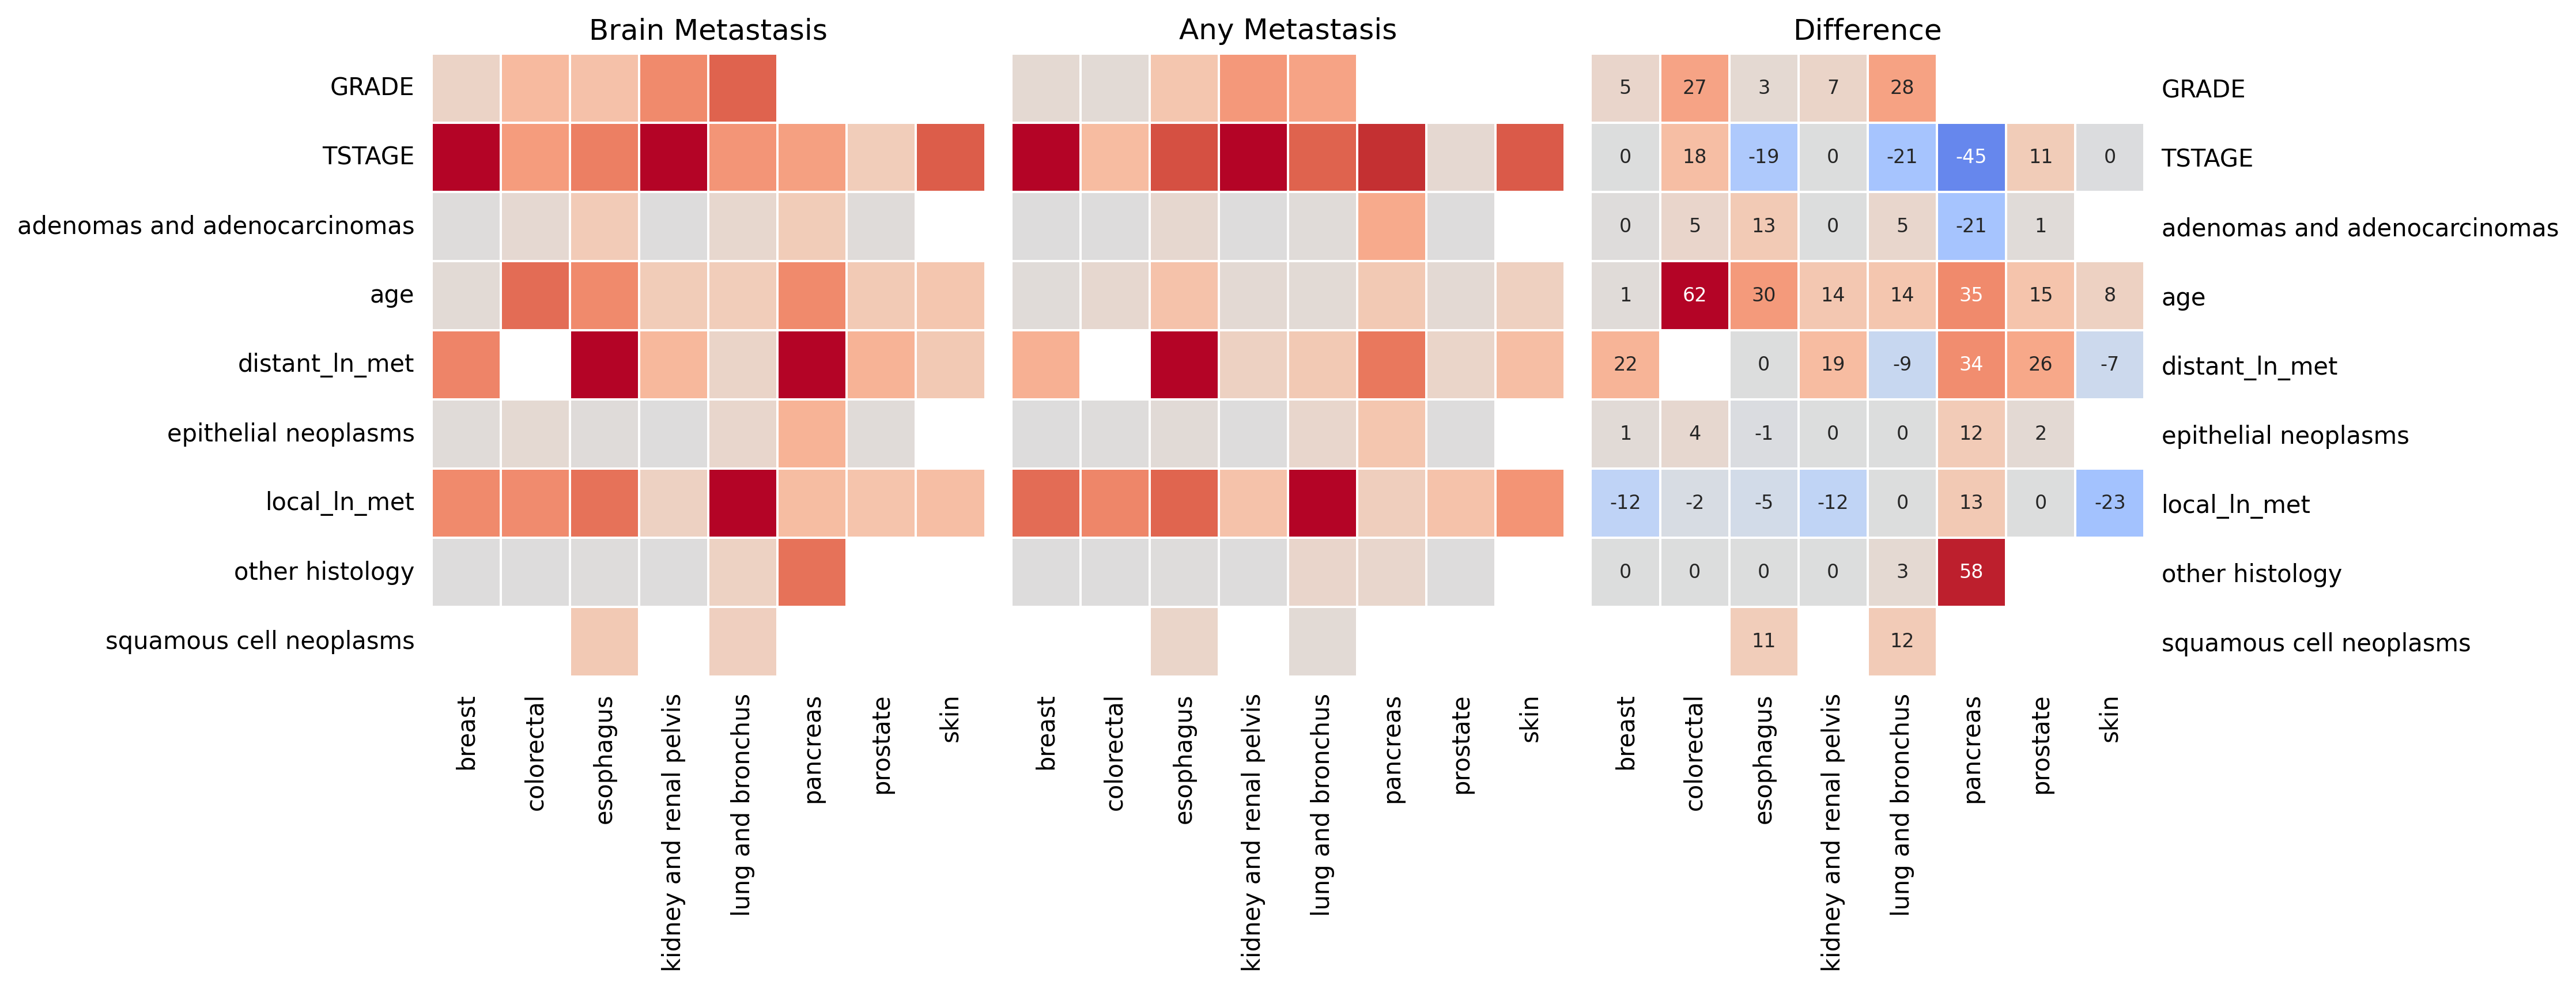

In [9]:
MIN_FEATURE_CANCER_GROUPS = 2
MODEL = 'decision_tree'

df = sframe.copy()
df['cancer_group'] = df['cancer_group'].apply(lambda x: x.replace('_', ' '))
fpresence = df.groupby('feature')['cancer_group'].value_counts().unstack().fillna(0).clip(upper=1).astype(bool)

# df['abs_importance'] = df['importance'].apply(lambda x: abs(x))
# print(df[df['cancer_group']=='breast'])
# df.groupby(['cancer_group', 'response'])['feature'].unique()
# print(fpresence.head())
# print()
# print(fpresence[fpresence.sum(axis=1)==fpresence.shape[1]])
# print()

selected_runs = [
    ('breast', 'brain_met', '1', '1'),
    ('colorectal', 'brain_met', '0', 'NA'),
    ('esophagus', 'brain_met', '1', '1'),
    ('kidney and renal pelvis', 'brain_met', '1', '1'),
    ('lung and bronchus', 'brain_met', '0', 'NA'),
    ('pancreas', 'brain_met', '1', '1'),
    ('prostate', 'brain_met', '1', '1'),
    ('skin', 'brain_met', '0', 'NA'),
    
    ('breast', 'any_met', '0', 'NA'),
    ('colorectal', 'any_met', '0', 'NA'),
    ('esophagus', 'any_met', '0', 'NA'),
    ('kidney and renal pelvis', 'any_met', '0', 'NA'),
    ('lung and bronchus', 'any_met', '0', 'NA'),
    ('pancreas', 'any_met', '0', 'NA'),
    ('prostate', 'any_met', '0', 'NA'),
    ('skin', 'any_met', '0', 'NA'),
]

# remove non-optimal (non-selected) runs
for cgroup, response, n_missing, n_neighbors in selected_runs:
    mask = (df['cancer_group']==cgroup) & (df['response']==response) & (df['n_missing']!=n_missing) & (df['n_neighbors']!=n_neighbors)
    df = df.loc[~mask]

def normalised_feature_importance_pivot(df: pd.DataFrame, model: str, response: str) -> pd.DataFrame:
    dfslice = df[(df['model']==model) & (df['response']==response)]
    fframe = dfslice.pivot(index='feature', columns='cancer_group', values='importance')

    # TODO normalise better. This doesn't preserve negative coefficients. 
    for cgroup in fframe.columns:
        fframe[cgroup] = fframe[cgroup].apply(lambda x: abs(x))
        vmax = fframe[cgroup].max()
        fframe[cgroup] = fframe[cgroup].apply(lambda x: x/vmax)
    return fframe

def filter_and_standardise(bframe: pd.DataFrame, aframe: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    bmet_feature_counts = bframe.notna().sum(axis=1).to_dict()
    amet_feature_counts = aframe.notna().sum(axis=1).to_dict()
    all_features = set(bmet_feature_counts.keys()) & set(amet_feature_counts.keys())
    valid_features = [f for f in all_features if bmet_feature_counts[f]>=MIN_FEATURE_CANCER_GROUPS and amet_feature_counts[f]>=MIN_FEATURE_CANCER_GROUPS]
    bframe = bframe.loc[valid_features]
    aframe = aframe.loc[valid_features]
    bframe = bframe.sort_index()
    aframe = aframe.sort_index()
    return bframe, aframe

brain_pivot = normalised_feature_importance_pivot(df, model=MODEL, response='brain_met')
any_pivot = normalised_feature_importance_pivot(df, model=MODEL, response='any_met')
brain_pivot, any_pivot = filter_and_standardise(brain_pivot, any_pivot)
diff_pivot = brain_pivot - any_pivot
diff_pivot_annot = diff_pivot.copy()
diff_pivot_annot = diff_pivot_annot.fillna(0)
for field in diff_pivot_annot:
    # # uncomment for absolute values in diff heatmap 
    # diff_pivot_annot[field] = diff_pivot_annot[field].apply(lambda x: abs(int(x*100)))
    diff_pivot_annot[field] = diff_pivot_annot[field].apply(lambda x: int(x*100))
# print(diff_pivot_annot) 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True, dpi=300)
sns.heatmap(brain_pivot, square=True, cmap='coolwarm', center=0, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(any_pivot, square=True, cmap='coolwarm', center=0, linewidth=.5, ax=axes[1], cbar=False)
sns.heatmap(diff_pivot, annot=diff_pivot_annot, annot_kws={"size": 8}, square=True, cmap='coolwarm', center=0, linewidth=.5, ax=axes[2], cbar=False)
axes[0].set_title('Brain Metastasis')
axes[1].set_title('Any Metastasis')
axes[2].set_title('Difference')
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].tick_params(left=False, labelleft=True, bottom=False, labelbottom=True)
axes[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=True)
axes[2].tick_params(left=False, labelleft=False, right=False, labelright=True, bottom=False, labelbottom=True)
axes[2].tick_params(axis='y', rotation=0)
plt.tight_layout()
outfile = f"/home/grace/work/SEER/outputs/figure3/feature_importance_{MODEL}.png"
plt.savefig(outfile)
plt.show()


In [ ]:
# table[(table[response]==True) & (table['cancer_group_CAT']=='Colorectal')]['distant_ln_met_BOOL'].value_counts()
table['hist_group_CAT'].value_counts().head(10)

In [ ]:
sys.exit()

### All Cancer Groups

In [50]:
def generate_sample_all_groups(dtable: pd.DataFrame, fcounts: dict[str, int], response: str) -> pd.DataFrame:
    """
    Generates a bootstrap sample. 
    Positive cases (brain_met|any_met true) within a cancer group will always be less than negative cases. 
    For this reason, want to fully sample positive cases (with replacement) and subsample negative cases to 
    avoid massive class imbalance. 

    The number of negative cases to select per cancer group are provided in `fcounts`. 
    These numbers are calculated using the ratio of positive:negative cases for the highest prevalence cancer group (lung).
    This ratio is used on all cancer groups, resulting in a balanced (1:1 ratio) of positive:negative cases for that high 
    prevalence group, while other cancers will still have an unbalanced (but reduced ratio). Preserves the relative positive:negative ratio of each cancer.
    """
    selected_indicies = set()
    for cgroup, nfalse in fcounts.items():
        # do bootstrapping with replacement
        idx_true_l = dtable[(dtable[cgroup]==1) & (dtable[response]==1)].index.to_list()
        idx_true_l = np.random.choice(idx_true_l, size=len(idx_true_l), replace=True)
        idx_false_l = dtable[(dtable[cgroup]==1) & (dtable[response]==0)].index.to_list()
        idx_false_l = np.random.choice(idx_false_l, size=nfalse, replace=False)
        assert all([x not in selected_indicies for x in idx_true_l])
        assert all([x not in selected_indicies for x in idx_false_l])
        selected_indicies.update(idx_true_l)
        selected_indicies.update(idx_false_l)
    dtable_s = dtable.loc[sorted(list(selected_indicies))].copy()
    return dtable_s

def do_run_all_groups(dtable: pd.DataFrame, fcounts: dict[str, int], response: str, budget: int=100) -> Tuple:
    dtable = dtable.reset_index(drop=True)

    # init results dataframes
    dt_features_frame = pd.DataFrame()
    dt_metrics_frame = pd.DataFrame()
    lr_features_frame = pd.DataFrame()
    lr_metrics_frame = pd.DataFrame()

    # bootstrap runs
    print()
    for i in range(budget):
        print(f"processed {i} bootstrap samples...", end='\r')
        # refresh results dataframes
        if i % 10 == 0:
            dt_features_frame = dt_features_frame.copy()
            dt_metrics_frame = dt_metrics_frame.copy()
            lr_features_frame = lr_features_frame.copy()
            lr_metrics_frame = lr_metrics_frame.copy()
        
        dtable_s = generate_sample_all_groups(dtable, fcounts, response)
        dt_sframe, dt_mseries, lr_sframe, lr_mseries = train_models(dtable_s, response, balanced=False)
        dt_features_frame[f"run{i}"] = dt_sframe['Importance']
        lr_features_frame[f"run{i}"] = lr_sframe['Coefficient']
        dt_metrics_frame[f"run{i}"] = dt_mseries
        lr_metrics_frame[f"run{i}"] = lr_mseries

    print(f"processed {i} bootstrap samples... done")
    return dt_features_frame, lr_features_frame, dt_metrics_frame, lr_metrics_frame
    

In [48]:
# ALL CANCER GROUPS
BUDGET = 100
response = 'brain_met_BOOL'
valid_cancer_groups = [
    'Breast', 
    'Colorectal', 
    'Esophagus', 
    'Kidney and Renal Pelvis',
    'Lung and Bronchus',
]
valid_hist_groups = [
    'adenomas and adenocarcinomas',
    'ductal and lobular neoplasms',
    'nevi and melanomas',
    'epithelial neoplasms',
    'squamous cell neoplasms',
    'cystic, mucinous and serous neoplasms',
    'transitional cell papillomas and carcinomas',
    'acinar cell neoplasms',
]

# generate Dtable
generator = AllGroupsDtableGenerator(table, valid_cancer_groups, valid_hist_groups, response)
dtable = generator.generate()

dtable_nm = dtable.dropna()
print(dtable_nm.head())
dtable_nm[response] = dtable_nm[response].map({True: 1, False: 0})

# fcounts for bootstrap sample generation
data = []
for field in valid_cancer_groups+['other primary']:
    cases = dtable_nm[field].sum()
    count_true = ((dtable_nm[field]==1) & (dtable_nm[response]==1)).sum()
    count_false = ((dtable_nm[field]==1) & (dtable_nm[response]==0)).sum()
    data.append((field, cases, count_true, count_false))
df = pd.DataFrame.from_records(data=data, columns=['cancer_group', 'cases', 'ntrue', 'nfalse'])
df['ratio'] = df['nfalse'] / df['ntrue']
condense_factor = df['ratio'].min()
df['fcount'] = df['nfalse'] / condense_factor
df['fcount'] = df['fcount'].apply(lambda x: int(x))
print()
print(df)
fcounts = df.set_index('cancer_group')['fcount'].to_dict()



cancer_group_CAT
other primary              1192127
Breast                      788100
Lung and Bronchus           395251
Colorectal                  369074
Kidney and Renal Pelvis     159187
Esophagus                    40143
Name: count, dtype: int64

hist_group_CAT
adenomas and adenocarcinomas                   1382538
ductal and lobular neoplasms                    748638
nevi and melanomas                              385341
epithelial neoplasms                            137794
squamous cell neoplasms                         109708
other histology                                  96018
cystic, mucinous and serous neoplasms            59163
transitional cell papillomas and carcinomas      12532
acinar cell neoplasms                            12150
Name: count, dtype: int64
['cancer_group_CAT', 'hist_group_CAT']
['GRADE_NUM', 'TSTAGE_NUM', 'age_NUM', 'distant_ln_met_NUM', 'local_ln_met_NUM']
    GRADE  TSTAGE   age  distant_ln_met  local_ln_met  Breast  Colorectal  Esophagus  Kid

In [51]:
# assess feature importance
dt_feats, lr_feats, dt_metrics, lr_metrics = do_run_all_groups(dtable_nm, fcounts, response=response, budget=BUDGET)


processed 99 bootstrap samples... done


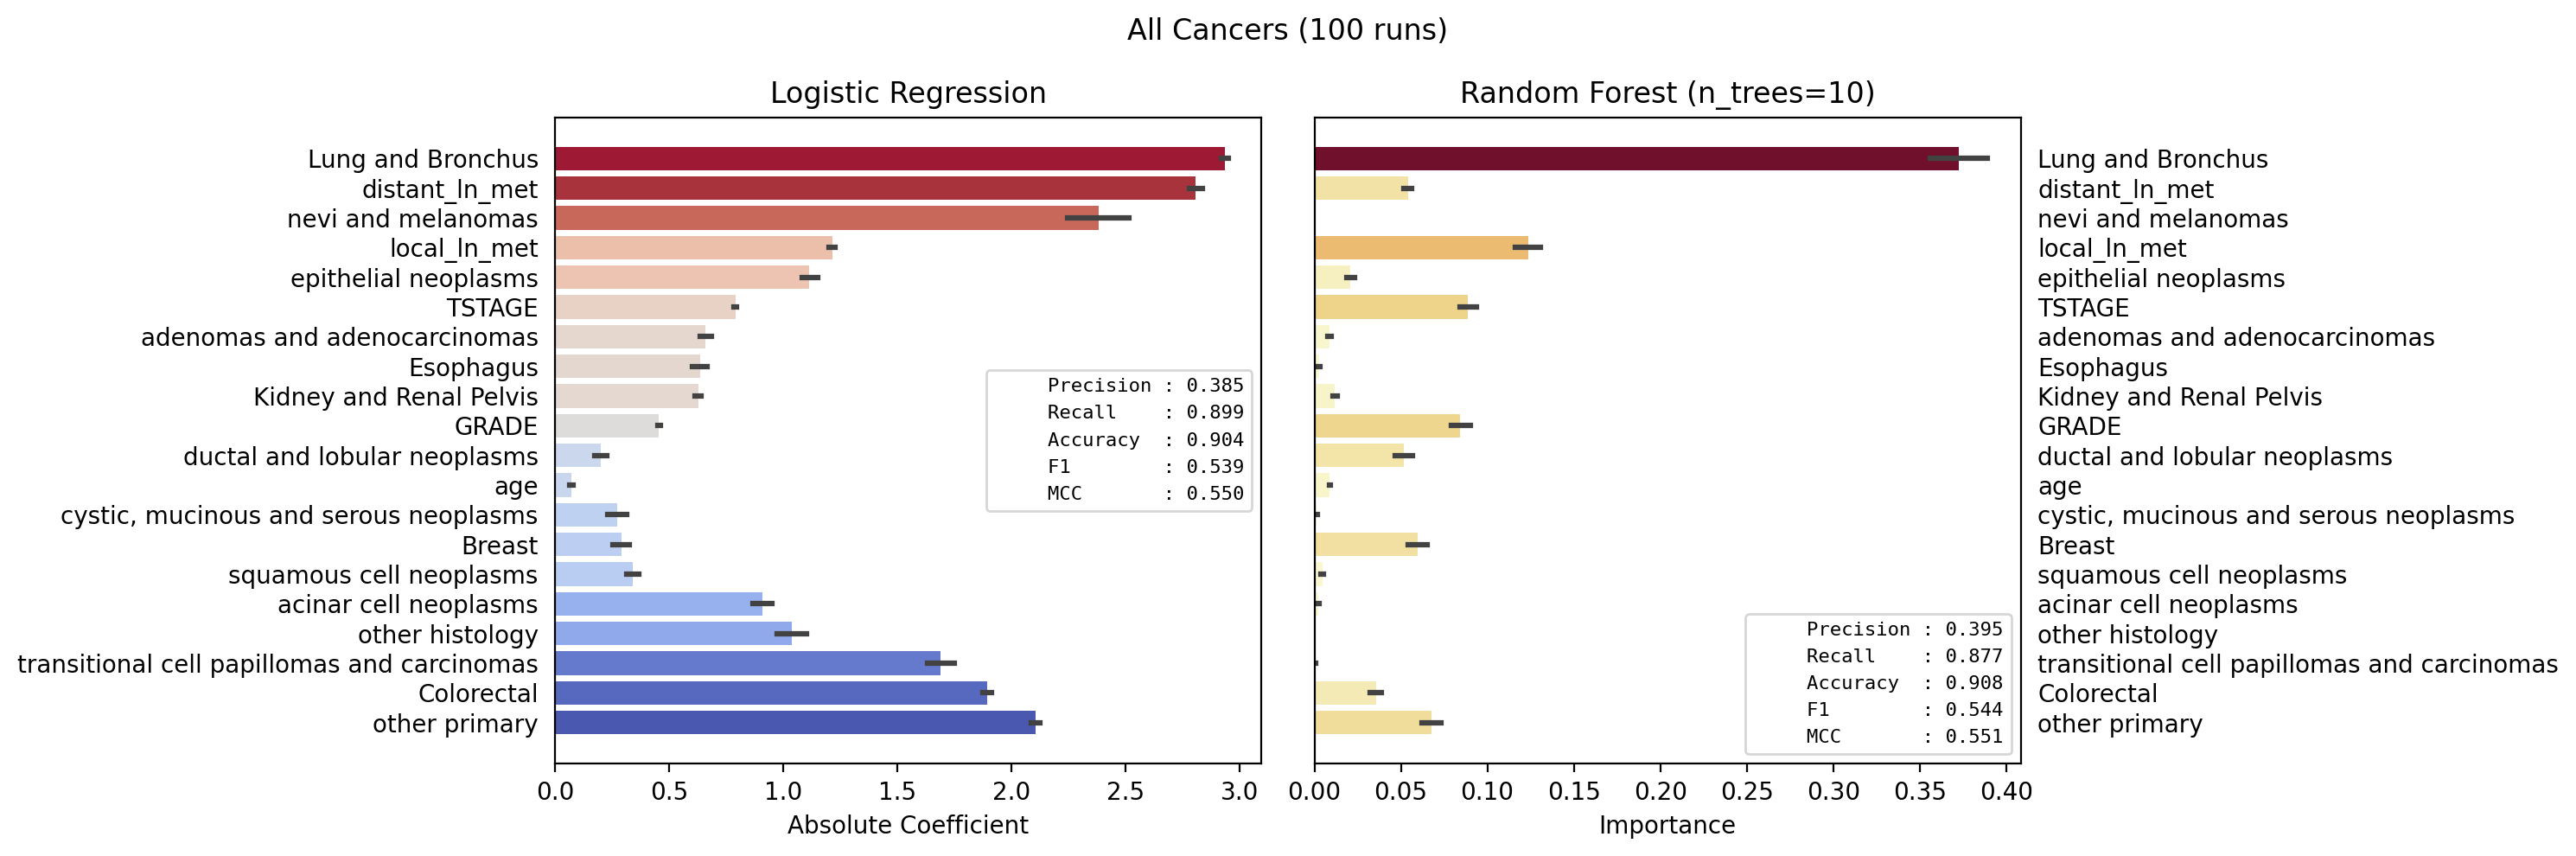

In [58]:
# plot
response_fmt = response.replace(' ', '_').replace('_BOOL', '').lower()
outfile = f"/home/grace/work/SEER/outputs/figure3/{response_fmt}/all_cancers.png"
title = f"All Cancers ({BUDGET} runs)"
_plot_results(outfile, title, dt_feats, lr_feats, dt_metrics, lr_metrics)

In [ ]:
# TODO
# - single model for all cancer_group (include epithelial etc hist types as predictors)
# - single model for all cancer_group:hist_group 


# def assess_feature_importance_all_groups(dtable: pd.DataFrame, response: str) -> None:

#     # fields either directly dropped, or used for KNN imputation (then dropped)
    
#     ignore = set()
#     ignore.update(constants.PREDICTOR_IGNORE_LUT['universal'])
#     ignore.update(constants.PREDICTOR_IGNORE_LUT[cgroup])
#     ignore_strict = sorted([x[0] for x in ignore if x[1]==False])
#     ignore_impute = sorted([x[0] for x in ignore if x[1]==True])
#     summarise_na(dtable, response, ignore_strict, ignore_impute)

#     # drop strict
#     dtable = dtable.drop(ignore_strict, axis=1).copy()
    
#     # n_missing, n_neighbors
#     runs = [
#         (0, None),
#         (1, 1),
#         (1, 3),
#     ]
#     for n_missing, n_neighbors in runs:
#         do_run_single_group(dtable.copy(), cgroup, response, n_missing, n_neighbors, ignore_impute)


# def report_imputation(dtable_raw: pd.DataFrame, dtable_imp: pd.DataFrame) -> None:
#     print('\nresponse=True ---')
#     for field in dtable_raw.columns:
#         print()
#         df = pd.DataFrame()
#         if dtable_s[field].nunique() > 10:
#             print(field)
#             df['raw'] = dtable_raw[field].describe()
#             df['imp'] = dtable_imp[field].describe()
#             df = df.fillna(0).T
#         else:
#             df['raw'] = dtable_raw[field].value_counts(dropna=False)
#             df['imp'] = dtable_imp[field].value_counts(dropna=False)
#             raw_notna = dtable_raw[field].notna().sum()
#             imp_notna = dtable_imp[field].notna().sum()
#             df = df.fillna(0).T
#             df['total'] = df.sum(axis=1)
#             df.loc['raw', 'notna'] = raw_notna
#             df.loc['imp', 'notna'] = imp_notna
#         print(df)

# def do_run_single_group(dtable: pd.DataFrame, cgroup: str, response: str, n_missing: int, n_neighbors: int|None, exclude: list[str]) -> None:

#     # imputation is performed separately for each class
#     dtable_pos = dtable[dtable[response]==True].drop([response], axis=1).copy()
#     dtable_neg = dtable[dtable[response]==False].drop([response], axis=1).copy()

#     # subset missing once
#     dtable_pos = subset_missing(dtable_pos, n_missing=n_missing, exclude=exclude)
#     dtable_neg = subset_missing(dtable_neg, n_missing=n_missing, exclude=exclude)

#     # handle na for positive class once
#     dtable_pos_i = handle_na_positive_class(dtable_pos, exclude, n_missing=n_missing, n_neighbors=n_neighbors)
#     dtable_pos_i[response] = True
#     target_records = dtable_pos_i.shape[0]

#     # init results dataframes
#     dt_features_frame = pd.DataFrame()
#     dt_metrics_frame = pd.DataFrame()
#     lr_features_frame = pd.DataFrame()
#     lr_metrics_frame = pd.DataFrame()

#     # bootstrap runs
#     BUDGET = 100
#     print()
#     for i in range(BUDGET):
#         print(f"processed {i} bootstrap samples...", end='\r')
#         # refresh results dataframes
#         if i % 10 == 0:
#             dt_features_frame = dt_features_frame.copy()
#             dt_metrics_frame = dt_metrics_frame.copy()
#             lr_features_frame = lr_features_frame.copy()
#             lr_metrics_frame = lr_metrics_frame.copy()
        
#         # handle na for positive class once
#         dtable_neg_i = handle_na_negative_class(dtable_neg, exclude, target_records, n_missing=n_missing, n_neighbors=n_neighbors)
#         dtable_neg_i[response] = False
#         dtable_merged = pd.concat([dtable_pos_i, dtable_neg_i], ignore_index=True)
#         dtable_merged = remove_invariant_predictors(dtable_merged, verbose=False)
#         if i == 0:
#             print()
#             print(dtable_merged[response].value_counts())
#         dtable_merged[response] = dtable_merged[response].map({True: 1, False: 0})

#         dt_sframe, dt_mseries, lr_sframe, lr_mseries = train_models(dtable_merged, response)
#         dt_features_frame[f"run{i}"] = dt_sframe['Importance']
#         lr_features_frame[f"run{i}"] = lr_sframe['Coefficient']
#         dt_metrics_frame[f"run{i}"] = dt_mseries
#         lr_metrics_frame[f"run{i}"] = lr_mseries

#     print(f"processed {i} bootstrap samples... done")
#     cgroup_fmt = cgroup.replace(' ', '_').lower()
#     response_fmt = response.replace(' ', '_').replace('_BOOL', '').lower()
#     nmiss_fmt = f"nmiss{n_missing}"
#     nneighbors_fmt = f"neighbors{n_neighbors}" if n_neighbors is not None else 'neighborsNA'
#     outdir = '/home/grace/work/SEER/outputs/figure3/'
#     outfile = f"{outdir}/{cgroup_fmt}_{response_fmt}_{nmiss_fmt}_{nneighbors_fmt}.png"
#     title = f"{cgroup} ({BUDGET} runs, {target_records} records per class, nmiss={n_missing}, nneighbors={n_neighbors})"
#     _plot_results(outfile, title, dt_features_frame, lr_features_frame, dt_metrics_frame, lr_metrics_frame)



In [ ]:
# dt_features_frame = dt_features_frame.copy()
# dt_metrics_frame = dt_metrics_frame.copy()
# lr_features_frame = lr_features_frame.copy()
# lr_metrics_frame = lr_metrics_frame.copy()

# print('\nDecision Tree Feature Importance')
# print(dt_features_frame)
# print('\nLogistic Regression Feature Coefficients')
# print(lr_features_frame)
# print('\nDecision Tree Metrics')
# print(dt_metrics_frame)
# print('\nLogistic Regression Metrics')
# print(lr_metrics_frame)


## Categorical

Clean and filter DataFrame

In [ ]:
# # CTYPE = 'Prostate'
# CTYPE = 'Lung and Bronchus'
# RESPONSE = 'brain_met'
# dtable_s = table[table['cancer_group']==CTYPE].copy()
# dtable_s = dtable_s[dtable_s[RESPONSE].notna()].copy()

# # define fields
# PREDICTORS = []
# PREDICTORS += ['age_bin', 'local_ln_met'] # omitted GSTAGE_STD_FMT
# PREDICTORS += constants.UNIVERSAL_PREDICTORS_CATEGORICAL
# PREDICTORS.remove('age')
# PREDICTORS.remove('sex')
# PREDICTORS.remove('GSTAGE_STD')
# PREDICTORS.remove('NSTAGE_STD')
# # # prostate 
# # PREDICTORS.remove('GRADE_STD')
# if CTYPE in constants.SPECIFIC_PREDICTORS_CATEGORICAL:
#     PREDICTORS += constants.SPECIFIC_PREDICTORS_CATEGORICAL[CTYPE]
# if CTYPE in constants.SPECIFIC_PREDICTORS_CONTINUOUS:
#     contpreds = constants.SPECIFIC_PREDICTORS_CONTINUOUS[CTYPE]
#     PREDICTORS += [CATEGORICAL_FIELDLABELS_LUT[pred] for pred in contpreds]
# # Lung 
# # PREDICTORS.remove('pleural_invasion')

# for field in PREDICTORS:
#     print(field)
# # # uncomment to check which fields to use
# # tmp = df[df[RESPONSE]==True]
# # for field in predictors:
# #     print()
# #     print(tmp[field].value_counts(dropna=False))

# # imputation
# IMPUTE_FIELDS_LUT = {
#     'TSTAGE_STD': 'T1',
#     'age_bin': '60-79 years', # NOTE: This must be manually set when changing age_bin binwidth.
    
#     # lung 
#     # 'GRADE_STD': 'G1',
#     # 'GSTAGE_STD_FMT': 'stage-I',
#     # 'distant_ln_met': False,
#     # 'pleural_invasion': 'PL0',
    
#     # prostate
#     # 'PSA_cat': 'mid (5.7-9.7)',
#     # 'gleason_cat': 'mid (7.0-7.0)',
# }
# for field, imputed_val in IMPUTE_FIELDS_LUT.items():
#     mask = dtable_s[field].isna()
#     dtable_s.loc[mask, field] = imputed_val

# # filtering
# print(f"{dtable_s.shape[0]}\t(start)")
# for field in PREDICTORS:
#     dtable_s = dtable_s[dtable_s[field].notna()]
# print(f"{dtable_s.shape[0]}\t(end)")

# # remapping categorical values for clarity
# CATVAL_MAP_LUT = {
#     # # prostate
#     # 'PSA_cat': lambda x: f"{x.split(' ')[0]} PSA",
#     # 'gleason_cat': lambda x: f"{x.split(' ')[0]} gleason",
# }
# for field, func in CATVAL_MAP_LUT.items():
#     dtable_s[field] = dtable_s[field].apply(func)
#     print()
#     print(dtable_s[field].value_counts(dropna=False))

# # remove low abundance histological types
# MIN_OBSERVATIONS = 10
# hcounts = dtable_s[dtable_s[RESPONSE]==True]['hist_group'].value_counts()
# print()
# print(hcounts)
# valid = hcounts[hcounts>MIN_OBSERVATIONS].index.to_list()
# dtable_s = dtable_s[dtable_s['hist_group'].isin(valid)]
# print()
# print(dtable_s['hist_group'].value_counts(dropna=False))

# # # balance brain met cases with no brain met
# # print()
# # print(dfslice[RESPONSE].value_counts(dropna=False))
# # dfslice = equalise_proportions(dfslice, boolfield=RESPONSE)
# # print()
# # print(dfslice[RESPONSE].value_counts(dropna=False))


Categorical values

In [ ]:
# def gen_dtable_categorical(df: pd.DataFrame) -> pd.DataFrame:
#     # define one-hot expanded fields and valid values
#     boolfields = ['local_ln_met', 'distant_ln_met']
#     dtable_fields = {}
#     for field in sorted(PREDICTORS):
#         if field in boolfields:
#             dtable_fields[field] = None
#         else:
#             dtable_fields[field] = sorted(list(df[field].unique()))

#     # generating boolean dtable
#     assert df['patient_id'].nunique() == df.shape[0]
#     df = df.set_index('patient_id')
#     dtable = pd.DataFrame(index=df.index, dtype=bool)
#     for field, fvals in dtable_fields.items():
#         if fvals is None:
#             dtable[field] = df[field].astype(bool)
#             continue 
#         for val in fvals:
#             dtable[val] = False
#             mask = df[field]==val
#             dtable.loc[mask, val] = True
#     dtable[RESPONSE] = df[RESPONSE].astype(bool)

#     # sanity check 
#     assert dtable.dropna().shape[0] == dtable.shape[0]
#     for col in dtable.columns:
#         assert dtable[col].nunique() > 1

#     return dtable


### Rules (you know the rules)

In [ ]:

# IFS = ' + '
# MIN_ITEMSET_SUPPORT = 0.05
# ASSOCIATION_METRIC = 'zhangs_metric'
# ASSOCIATION_THRESH = 0.01
# DISPLAY_FIELDS = ['antecedents', 'consequents', 'ante_support', 'cont_support', 'support', 'confidence', 'zhangs_metric']

# merulez = []
# for i in range(10):
#     print(i)
#     # balance brain met cases with no brain met
#     # print(df.shape)
#     btable = helpers.equalise_proportions(dtable_s, boolfield=RESPONSE)
#     # print(btable.shape)
#     self.dtable = gen_dtable_categorical(btable)
#     # print(dtable.shape)
#     # print(dtable.head(10))

#     # identify itemsets
#     itemsets = fpgrowth(self.dtable, min_support=MIN_ITEMSET_SUPPORT, use_colnames=True)

#     # association rules
#     rules = association_rules(itemsets, metric=ASSOCIATION_METRIC, min_threshold=ASSOCIATION_THRESH)
#     rules = rules.rename(columns={'antecedent support': 'ante_support', 'consequent support': 'cont_support'})
#     rules["antecedents"] = rules["antecedents"].apply(lambda x: IFS.join(list(x))).astype("unicode")
#     rules["consequents"] = rules["consequents"].apply(lambda x: IFS.join(list(x))).astype("unicode")
#     rules['antecedents'] = rules['antecedents'].apply(lambda x: IFS.join(sorted(x.split(IFS))))
#     rules['nAntes'] = rules['antecedents'].apply(lambda x: len(x.split(IFS)))
#     rules['nConts'] = rules['consequents'].apply(lambda x: len(x.split(IFS)))
#     rules['nMembers'] = rules['nAntes'] + rules['nConts']
#     rules = rules.sort_values(by=['confidence', 'zhangs_metric'], ascending=False)
#     # rules = rules.sort_values('support', ascending=False)
#     # rules = rules.sort_values('confidence', ascending=False)
#     # print(rules[DISPLAY_FIELDS].head(20))

#     tgt_rules = rules.copy()
#     tgt_rules = tgt_rules[tgt_rules['consequents']==RESPONSE]
#     nrules = tgt_rules.shape[0]
#     # tgt_rules = tgt_rules.sort_values(by=['zhangs_metric', 'confidence', 'support'], ascending=False)
#     tgt_rules = tgt_rules.sort_values(by=['confidence', 'support'], ascending=False)
#     # print()
#     # print(f"rules: {nrules}")
#     # print(tgt_rules[DISPLAY_FIELDS].head(10))
#     merulez.append(tgt_rules)


In [ ]:
# for i, t_rulez in enumerate(merulez):
#     t_rulez['run'] = f"run{i}"

# all_rulez = pd.concat(merulez, ignore_index=True)
# print(all_rulez.shape)
# sframe = pd.DataFrame(index=list(all_rulez['antecedents'].unique()))
# sframe['n_runs'] = all_rulez['antecedents'].value_counts()
# sframe = sframe.sort_values('n_runs')
# for field in ['ante_support', 'cont_support', 'support', 'confidence', 'zhangs_metric']:
#     ptable = all_rulez.pivot(index='antecedents', columns='run', values=field)
#     sframe[field] = ptable.mean(axis=1)

# sframe = sframe.reset_index()
# sframe = sframe.rename(columns={'index': 'features'})
# # sframe['features'] = sframe['features'].apply(lambda x: x.replace(';', ' + '))
# # sframe = sframe.sort_values('n_runs', ascending=False)
# sframe = sframe.sort_values('confidence', ascending=False)
# # sframe = sframe.sort_values('zhangs_metric', ascending=False)
# sframe.head(20)

In [ ]:
# import matplotlib.pyplot as plt

# sframe = sframe.head(18)
# labels = sframe.index.to_list()
# cmap = plt.get_cmap('Dark2')
# colors = [cmap(i) for i in range(8)] * 3
# markers = ['D', 'o', 's'] * 6

# plt.figure(figsize=(5, 5))
# for i, rec in enumerate(sframe.itertuples()):
#     plt.plot(rec.zhangs_metric, rec.confidence, color=colors[i], marker=markers[i], markersize=7, label=rec.features, linestyle='None', mec='white', mew=0.8)
# plt.title('ARL')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xlabel('Zhangs')
# plt.ylabel('Confidence')
# plt.show()

# # marker_lut

# # mapper = {}
# # for i in range(6):
# #     for j in range(3):
# #         label = labels[i+j]
# #         color = cmap(i)
# #         marker = markers[j]
# #         mapper[label] = {'color': color, 'marker': marker}


# # plt.scatter(x_values, y_values)
# # plt.show()

In [ ]:
# all_rulez[all_rulez['antecedents']=='adenomas and adenocarcinomas;distant_ln_met;mid gleason']

<br><br><br>

-------------
### CHOPPED SHYT

In [ ]:

# # imputation / filtering
# IMPUTE_LUT = {
#     'TSTAGE_STD': 'T1',
#     'age_bin': '60-79 years', # NOTE: This must be manually set when changing age_bin binwidth.
#     # 'GRADE_STD': 'G1',
#     # 'GSTAGE_STD_FMT': 'stage-I',
#     # 'distant_ln_met': False,
#     # 'pleural_invasion': 'PL0',
#     'pleural_invasion': None,
#     'GRADE_STD': None,
#     'distant_ln_met': None,
#     'hist_group': None, 
#     'local_ln_met': None, 
#     'sex': None, 
# }

# print(f"{dfslice.shape[0]}\t(start)")
# for field, ival in IMPUTE_LUT.items():
#     validvals = VALIDVALS_LUT[field]
#     # print()
#     # print(field)
#     # for val in validvals:
#     #     print(f"- {val} ({type(val)})")
#     if ival is None:
#         dfslice = dfslice[dfslice[field].isin(validvals)]
#     else:
#         mask = ~dfslice[field].isin(validvals)
#         dfslice.loc[mask, field] = ival
#     # print(f"{dfslice.shape[0]}\t({field})")
# print(f"{dfslice.shape[0]}\t(end)")

# # balance brain met cases with no brain met
# dfslice = equalise_proportions(dfslice, boolfield=RESPONSE)

# # sanity check 
# for field, validvals in VALIDVALS_LUT.items():
#     print()
#     print(dfslice[field].value_counts(dropna=False))
#     assert sorted(list(dfslice[field].unique())) == validvals



In [ ]:
# for cancer_group, predictors in constants.SPECIFIC_PREDICTORS_CONTINUOUS.items():
#     for pred in predictors:
#         print()
#         print(cancer_group, pred)
#         dfslice = table[table['cancer_group']==cancer_group].copy()
        
#         # numeric
#         fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
#         nunique = dfslice[pred].nunique()
#         sns.histplot(data=dfslice, x=pred, bins=min(nunique, 10), ax=axes[0])

#         # mask and valid values
#         mask = dfslice[pred].notna()
#         validvals = dfslice[mask][pred]
        
#         # mapped to categorical3 
#         newfield = f"{pred}_cat3"
#         dfslice[newfield] = pd.NA 
#         dfslice.loc[mask, newfield] = categorise(validvals, preferred_q=3)
#         sns.histplot(data=dfslice, x=newfield, ax=axes[1])
        
#         # mapped to categorical2 
#         newfield = f"{pred}_cat2"
#         dfslice[newfield] = pd.NA 
#         dfslice.loc[mask, newfield] = categorise(validvals, preferred_q=2)
#         sns.histplot(data=dfslice, x=newfield, ax=axes[2])
#         plt.show()

